## SoftMax Model Implementation for Cancer Dataset

### ML for Scientists Project: Prediction of Disease Type Based on Underlying Mechanisms: Gene Expression versus Post-Transcriptional Drivers

### Overview of Workflow

1. **Preprocessing**
   - Drop non-feature columns (`donor_id`, `sex`, etc.)
   - One-hot encode categorical features (if present)
   - Convert all features to numeric
   - Separate labels (`y_train`, `y_test`) and donor groups (`train_groups`)

2. **Train/Test Split**
   - Use `StratifiedGroupKFold` to create a **donor-aware split**
   - Ensures:
     - **No donor ID overlap** between train/test
     - **Stratification by disease labels** to preserve class balance

3. **Group-Aware Cross-Validation + Hyperparameter Tuning**
   - Use `StratifiedGroupKFold` within the training set to define **donor-aware folds**
   - For each combination of hyperparameters:
     - Evaluate cross-validation accuracy **in parallel** using `joblib.Parallel`
     - Use mean accuracy across folds to pick best hyperparameters

4. **Final Model Training**
   - Standardize training features (z-score using training set mean/SD)
   - Train softmax model using **best hyperparameters**

5. **Final Evaluation on Held-Out Test Set**
   - Apply **same standardization (mean, SD from train set)** to test data
   - Predict disease labels on test set
   - Report:
     - Test accuracy
     - Precision, recall, F1-score
     - Confusion matrix
     - ROC-AUC (True Positive Rate vs. False Positive Rate); AUC=1.0 (perfect classifier), 0.5 (no better than random), <0.5 (worse than random)
     - Feature Importance: Identified genes and other features with large weight magnitudes in Softmax.

---

### Notes on Standardization
- Standardization is always done **after train/test split** to avoid **data leakage**
- **Must standardize** the data:
  - Before **each fold** during CV (using that fold’s training stats)
  - Once before **final model training** on full train set
  - Apply same stats to the test set


In [1]:
# Package imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import Parallel, delayed
from sklearn.preprocessing import label_binarize
from sklearn.metrics        import roc_curve, auc

# Load data: uncomment full_csv if uploading a large file; if train/test split datasets available, load accoridngly.

data_folder = os.path.join("..", "..", "data")

# Full dataset
# full_csv  = os.path.join(data_folder, "neuro_dataset.csv")

# Train/Test split files
train_csv = os.path.join(data_folder, "train_neuro.csv")
test_csv  = os.path.join(data_folder, "test_neuro.csv")
#train_csv = None
#est_csv = None


In [2]:
# Locate the key-columns for splits and training
label_col = "disease"
group_col = "donor_id"
#y = df[label_col]
#groups = df[group_col]

if train_csv and test_csv and os.path.exists(train_csv) and os.path.exists(test_csv):
    df_train = pd.read_csv(train_csv)
    df_test  = pd.read_csv(test_csv)
    print("Data loaded from the provided files.")
else:
    print("Data loaded from the full .csv file.")
    df       = pd.read_csv(full_csv)
    y        = df[label_col]
    groups   = df[group_col]
    # StratifiedGroupKFold split ensuring donor-id separation (non-overlap) and roughly equal proportions of labels.
    # n_splits: K-folds, shuffle: randomizes data before plitting; stochastic reproducibility achieved by setting random_state seed.
    splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=38)
    # Based on groups, prevents donor-overlaps
    for train_idx, test_idx in splitter.split(df, y, groups): #
        df_train = df.iloc[train_idx].copy()
        df_test  = df.iloc[test_idx].copy()
        break
    assert not set(df_train[group_col]) & set(df_test[group_col]), "Detected donor overlap!"

    
# Print label proportions for balance check: 
train_dist = df_train[label_col].value_counts(normalize=True).rename("train %")
test_dist = df_test[label_col].value_counts(normalize=True).rename("test %")
print(pd.concat([train_dist, test_dist], axis=1))

Data loaded from the provided files.
                                 train %    test %
disease                                           
Alzheimer disease               0.272876  0.251309
progressive supranuclear palsy  0.261438  0.251309
normal                          0.246732  0.246073
Pick disease                    0.218954  0.251309


In [3]:
# Pre-training data processing (one-hot encoding, data type conversions, label extraction)

# 1: Drop known non-feature columns but keep categorical ones for now
drop_before_encoding = ["donor_id", "development_stage", "sex", "disease"]
df_train_features = df_train.drop(columns=drop_before_encoding)
df_test_features  = df_test.drop(columns=drop_before_encoding)

# 2: Detect categorical columns to encode (if any)
categorical_cols = df_train_features.select_dtypes(include=["object", "category"]).columns.tolist()

# Only if applicable
if categorical_cols:
    # Apply one-hot encoding only if needed
    X_train_encoded = pd.get_dummies(df_train_features, columns=categorical_cols)
    X_test_encoded  = pd.get_dummies(df_test_features, columns=categorical_cols)

    # Align test features to match training columns
    X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
else:
    # No categorical columns; use features as-is
    X_train_encoded = df_train_features.copy()
    X_test_encoded  = df_test_features.copy()

# 3: Convert to floats for SoftMax
X_train = X_train_encoded.astype(float)
X_test = X_test_encoded.astype(float)

# 4: Extract labels and group info
y_train = df_train["disease"]
y_test  = df_test["disease"]
train_groups = df_train["donor_id"]

# 5: Standardize based on training stats (Optional test)
#mu = X_train.mean()
#sd = X_train.std().replace(0, 1)
#X_train_z = (X_train - mu) / sd
#X_test_z  = (X_test  - mu) / sd


In [4]:
# Construct the Softmax Multivariate Logistic Regression

class SoftmaxRegression:
    '''
    Goal: Initializes the instances and sets random seed and other hyperparameters.
    Inputs: Self is instance of the class on which method is called; rest of the inputs are hyperparameters.
    Ouput: None.
    '''
    def __init__(self, lr=0.1, epochs=1000, reg_lambda=0.0, batch_size=None, seed=0):
        """
        lr         : learning rate η (gradient descent step-sizze)
        epochs     : number of passes over the full training data
        reg_lambda : L2 regularization strength (λ)
        batch_size : if None, full-batch GD; else mini-batch size
        seed       : random seed for reproducibility
        """
        # Another area for improvement is to tune these hyperparameters and evaluate if generalized performance improves.
        self.lr         = lr
        self.epochs     = epochs # number of passes over the full training set
        self.reg_lambda = reg_lambda # penalizes large weights; prevents overfitting
        self.batch_size = batch_size
        np.random.seed(seed) # for repeatability using the Pseudo-Random Number Generator

    '''
    Goal: Calculates the softmax conversion.
    Input: Instance of class, the logit Z.
    Ouput: Returns the softmax function output.
    '''
    def _softmax(self, Z):
        """
        Numerically-stable softmax:
          Z is shape (n_samples, n_classes)
          Mathematically, Z=XW+b
          returns P_ik = exp(Z_ik) / Σ_j exp(Z_ij)
          where Z_ik = (W^T * x_i + b)_k <-- raw score (logit) for sample i (datapoint) and class k (disease); shape is n_samples(datapoint) x n_samples(datapoint).
          Z value is also called the logits (raw score).

        Indices:
        i : Sample index (datapoints or rows) from 1 to N
        j : Sum over all possible classes for sample i
        k : Class index for current element
        """
        Z = Z - Z.max(axis=1, keepdims=True) # Subtract row max to avoid large exponential values.
        # Here, "keepdims=True" ensures it returns (N,1) so that each row can be divided elementwise.
        # axis=1 sums across columns (classes)
        expZ = np.exp(Z)
        return expZ / expZ.sum(axis=1, keepdims=True) # Returns the Softmax regression function.

    '''
    Goal: Calculates the regularized loss function (including the l2 normalization and the cross-entropy loss)
    Input: Instance of the class, predicted class probabilities P from Softmax function, and Y is the true label matrix (one-hot encoded).
    Output: Returns the value of the regularized loss.
    '''
    def _loss(self, P, Y):
        """
        Measures how bad a model is doing; minimize this loss function.
        Cross-entropy + L2 loss:
          CE = -(1/N) Σ_i Σ_k Y_ik log P_ik
          L2 = (λ/2) ‖W‖²
          Loss = CE+L2
        """
        N = Y.shape[0]
        ce = -np.sum(Y * np.log(P + 1e-12)) / N
        # L2 regularization (bridge) makes the model prefer small-magnitude weights.
        l2 = 0.5 * self.reg_lambda * np.sum(self.W * self.W)
        return ce + l2
    ''' 
    Goal: Calls other functions defined above to perform the fit.
    Input: Instance of self, X data frame (features), y (labels)
    Output: None.
    '''
    def fit(self, X_df, y_series):
        """
        Train the model on DataFrame X_df and Series y_series.
        Internally one-hot encodes y_series to Y (N×K).
        """
        X = X_df.to_numpy()                # (N, D)
        # one‑hot encode labels (built-in):
        classes    = sorted(y_series.unique()) # get sorted list of unique class labels (for column-ordering of one-hot labels)
        cls_to_idx = {c:i for i,c in enumerate(classes)} # dictionary mapping from class label to integer index
        y_int      = y_series.map(cls_to_idx).to_numpy()
        Y          = np.zeros((len(y_int), len(classes)))
        Y[np.arange(len(y_int)), y_int] = 1.0 # Assigns 1 denoting the correct class column for each sample

        N, D = X.shape
        K    = Y.shape[1]

        # Xavier/Glorot initialization (sampling from a random distribution with variance inversely proportional to nuber of features, D)
        self.W = np.random.randn(D, K) / np.sqrt(D)
        self.b = np.zeros((1, K))
        self.classes_ = classes

        bs = self.batch_size or N

        for epoch in range(1, self.epochs + 1):
            # shuffle the data each epoch
            perm = np.random.permutation(N)
            X, Y = X[perm], Y[perm]

            for start in range(0, N, bs):
                end = start + bs
                Xb  = X[start:end]   # (bs, D)
                Yb  = Y[start:end]   # (bs, K)
                m   = Xb.shape[0]

                # forward pass: compute class scores then probabilities (Forward Pass includes calculation of class probabilities)
                logits = Xb @ self.W + self.b      # (bs, K)
                P      = self._softmax(logits)     # (bs, K)

                # gradient of loss w.r.t. logits: (P – Y) / m
                dZ = (P - Yb) / m                  # (bs, K)
                # backprop to W and b (calculate change in loss due to weights and biases respectively)
                dW = Xb.T @ dZ + self.reg_lambda * self.W  # (D, K)
                db = dZ.sum(axis=0, keepdims=True)         # (1, K)

                # gradient step (calculate new weights and biases to pass to the next epoch)
                self.W -= self.lr * dW
                self.b -= self.lr * db

            # optionally print loss occasionally
            if epoch == 1 or epoch % 100 == 0:
                P_all = self._softmax(X @ self.W + self.b)
                loss  = self._loss(P_all, Y)
                print(f"epoch {epoch:4d}  loss {loss:.4f}")

    ''' 
    Goal: Predict the class probabilities using Softmax function
    Input: Self instance of the class, X dataframe consisting of features
    Output: Class probabilities.
    '''
    def predict_proba(self, X_df):
        """Return the (N, K) matrix of class probabilities."""
        X = X_df.to_numpy()
        logits = X @ self.W + self.b
        return self._softmax(logits)
    ''' 
    Goal: Calculates the series of predicted disease labels.
    Input: Self instance and features dataframe.
    Output: The predicted classes in series.
    '''
    def predict(self, X_df):
        """Return a pandas Series of the predicted class labels."""
        P   = self.predict_proba(X_df)
        idx = np.argmax(P, axis=1)
        return pd.Series([self.classes_[i] for i in idx], index=X_df.index)


In [5]:
# Perform Cross-Validation

''' 
Goal: First perform the single fold fit and accuracy calculation. Perform standardization within.
'''
def run_single_fold(X_df, y_series, train_idx, val_idx, model_class, model_kwargs):
    # Split fold
    X_tr, X_val = X_df.iloc[train_idx], X_df.iloc[val_idx]
    y_tr, y_val = y_series.iloc[train_idx], y_series.iloc[val_idx]
    # Standardize on fold train
    mu = X_tr.mean()
    sd = X_tr.std().replace(0, 1)
    X_tr_z  = (X_tr  - mu) / sd
    X_val_z = (X_val - mu) / sd
    # Fit & score
    model = model_class(**model_kwargs)
    model.fit(X_tr_z, y_tr)
    y_pred = model.predict(X_val_z)
    return accuracy_score(y_val, y_pred)

# CV + hyperparameter search with per‐fold accuracies
''' 
Goal: Perform cross-validation in parallel using joblib package; perform hyperparameter tuning as well using mean performance.
'''
def run_group_cv_parallel(X_df, y_series, group_series,
                          model_class, param_grid,
                          n_splits=5, n_jobs=-1):
    splitter = StratifiedGroupKFold(n_splits=n_splits,
                                    shuffle=True,
                                    random_state=42)
    splits = list(splitter.split(X_df, y_series, groups=group_series))
    results = []

    for params in param_grid:
        print("Testing:", params)
        # parallel fold runs
        scores = Parallel(n_jobs=n_jobs)(
            delayed(run_single_fold)(
                X_df, y_series,
                train_idx, val_idx,
                model_class, params
            )
            for train_idx, val_idx in splits
        )
        print(f"→ Fold Accuracies: {scores}")
        mean_acc = np.mean(scores)
        print(f"→ Mean CV Accuracy: {mean_acc:.4f}\n")
        results.append({
            "params": params,
            "fold_accuracies": scores,
            "mean_cv_accuracy": mean_acc
        })

    return pd.DataFrame(results).sort_values(
        by="mean_cv_accuracy", ascending=False
    )

# Hyperparameter tuning performed for different values of selected hyper-parameters.
param_grid = [
    {"lr": lr, "epochs": 500, "reg_lambda": reg, "batch_size": 128}
    for lr in [0.01, 0.05, 0.1]
    for reg in [0.0, 1e-4, 1e-3, 1e-2]
]

# Execute CV in parallel
cv_results = run_group_cv_parallel(
    X_train, y_train, train_groups,
    SoftmaxRegression, param_grid,
    n_splits=5, n_jobs=-1
)



Testing: {'lr': 0.01, 'epochs': 500, 'reg_lambda': 0.0, 'batch_size': 128}


epoch    1  loss 1.3411
epoch    1  loss 1.3485
epoch    1  loss 1.4528
epoch    1  loss 1.3697
epoch    1  loss 1.3535
epoch  100  loss 0.0878
epoch  100  loss 0.1005
epoch  100  loss 0.1046
epoch  100  loss 0.1044
epoch  100  loss 0.0907
epoch  200  loss 0.0438
epoch  200  loss 0.0513
epoch  200  loss 0.0534
epoch  200  loss 0.0529
epoch  200  loss 0.0456
epoch  300  loss 0.0290
epoch  300  loss 0.0343
epoch  300  loss 0.0355
epoch  300  loss 0.0352
epoch  300  loss 0.0303
epoch  400  loss 0.0216
epoch  400  loss 0.0257
epoch  400  loss 0.0265
epoch  400  loss 0.0263
epoch  400  loss 0.0227
epoch  500  loss 0.0172
epoch  500  loss 0.0205
epoch  500  loss 0.0212
epoch  500  loss 0.0209
epoch  500  loss 0.0181
→ Fold Accuracies: [0.3125, 0.3218390804597701, 0.3865546218487395, 0.3333333333333333, 0.33070866141732286]
→ Mean CV Accuracy: 0.3370

Testing: {'lr': 0.01, 'epochs': 500, 'reg_lambda': 0.0001, 'batch_size': 128}
epoch    1  loss 1.4530
epoch    1  loss 1.3699
epoch  100  loss 

In [6]:
# Print the best hyper-parameters identified in the previous step.
best_params = cv_results.iloc[0]["params"]
print("Best Hyperparameters:", best_params)

# Final Training with Best Params
# Re-standardize with entire train set
mu = X_train.mean()
sd = X_train.std().replace(0, 1)
X_train_z = (X_train - mu) / sd
X_test_z  = (X_test  - mu) / sd

final_model = SoftmaxRegression(**best_params)
final_model.fit(X_train_z, y_train)

Best Hyperparameters: {'lr': 0.01, 'epochs': 500, 'reg_lambda': 0.0, 'batch_size': 128}
epoch    1  loss 1.3813
epoch  100  loss 0.1119
epoch  200  loss 0.0578
epoch  300  loss 0.0387
epoch  400  loss 0.0291
epoch  500  loss 0.0232


In [7]:
# Perform Final Test Evaluation on the test dataset
y_pred = final_model.predict(X_test_z)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred))

# Define label order: put "Normal" first, then the rest alphabetically
all_labels = sorted(y_test.unique())
labels = ["normal"] + [lbl for lbl in all_labels if lbl != "normal"]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=labels))


Final Test Accuracy: 0.42408376963350786

Classification Report:
                                precision    recall  f1-score   support

                        normal       0.67      0.85      0.75        47
             Alzheimer disease       0.26      0.19      0.22        48
                  Pick disease       0.33      0.42      0.37        48
progressive supranuclear palsy       0.33      0.25      0.29        48

                      accuracy                           0.42       191
                     macro avg       0.40      0.43      0.40       191
                  weighted avg       0.40      0.42      0.40       191



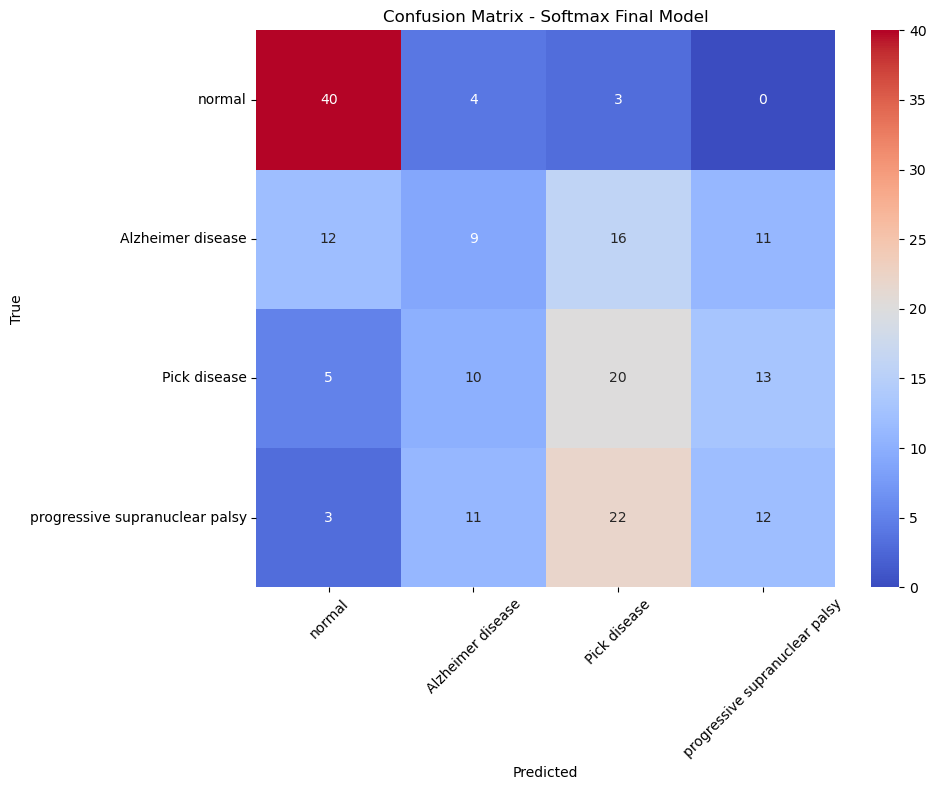

In [8]:
# ANALYSIS 1: Confusion Matrix
''' A confusion matrix provides a detailed breakdown of correct and incorrect predictions by showing how often predicted labels match the true labels for each class. It helps identify specific classes that are miscalssified or overrepresented.'''


# Compute confusion matrix with this specific label order
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Confusion Matrix - Softmax Final Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

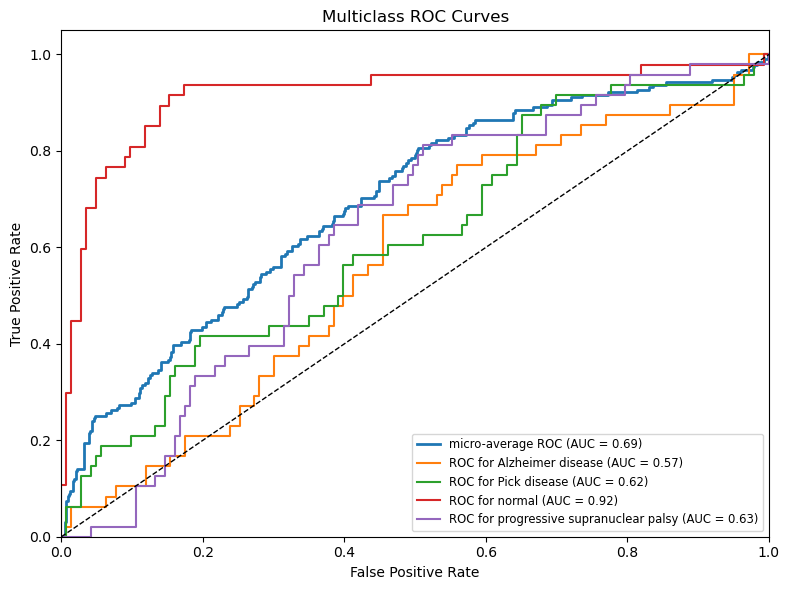

In [9]:
# ANALYSIS 2: ROC Curves and AUC indicating
'''The ROC (Receiver Operating Characteristic) curve illustrates the trade-off between true positive rate (sensitivity) and false positive rate across different classification thresholds, providing insight into the model’s discrimination ability. The AUC (Area Under the Curve) summarizes this performance into a single number; closer to 1.0 indicates better separability between classes. Together, these metrics offer a comprehensive picture of both overall and class-wise model performance.'''
# ROC curves & AUC for multiclass


# Binarize the true test labels
classes = final_model.classes_
y_test_bin = label_binarize(y_test, classes=classes)
n_classes  = y_test_bin.shape[1]

# Get predicted probabilities
y_score = final_model.predict_proba(X_test_z)

# Compute ROC curve and AUC for each class
fpr = dict(); tpr = dict(); roc_auc = dict()
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _    = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i]           = auc(fpr[i], tpr[i])

# Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"]              = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         linewidth=2)
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label=f'ROC for {cls} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()



/var/folders/82/xgfcbtyj0mv3n0f77cv0vkdr0000gn/T/ipykernel_81136/251153931.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


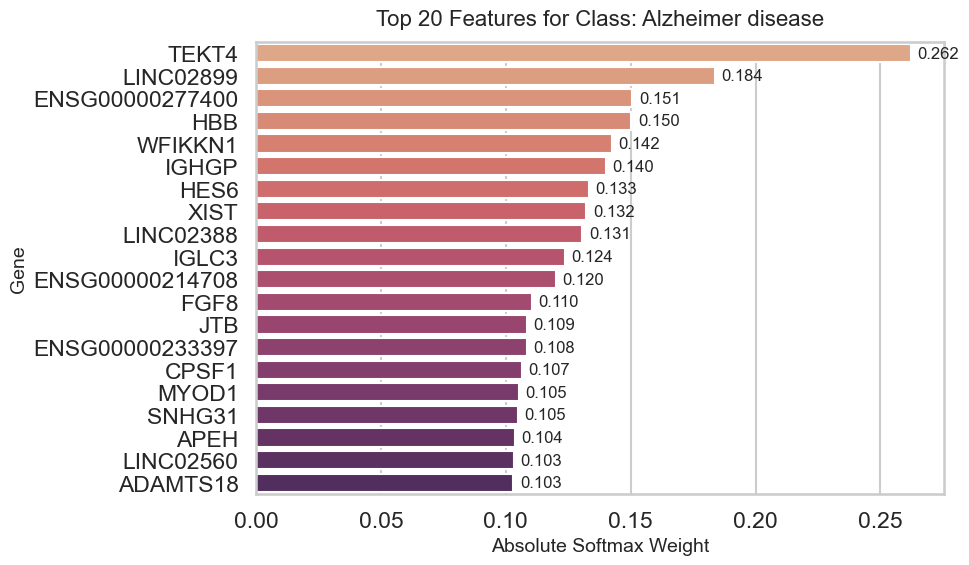

/var/folders/82/xgfcbtyj0mv3n0f77cv0vkdr0000gn/T/ipykernel_81136/251153931.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


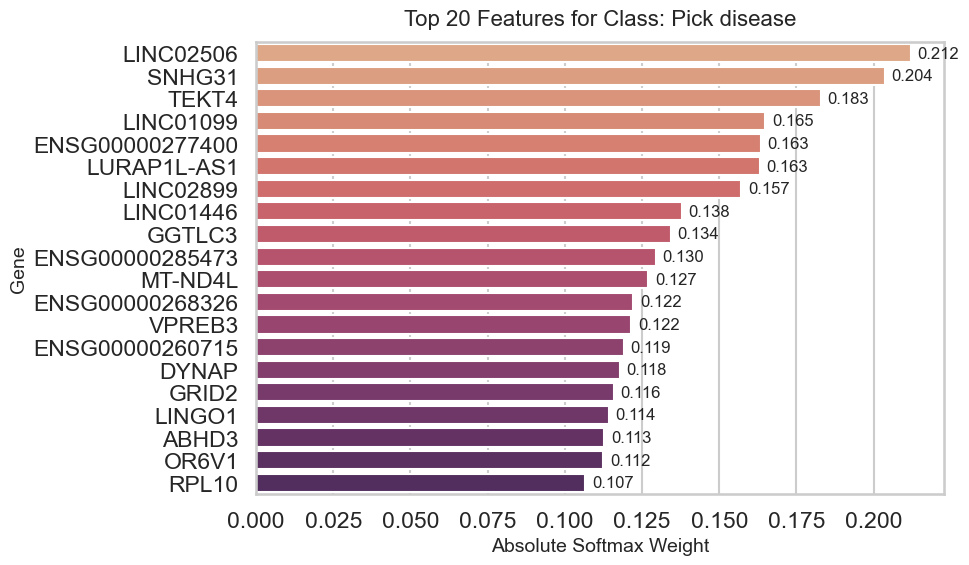

/var/folders/82/xgfcbtyj0mv3n0f77cv0vkdr0000gn/T/ipykernel_81136/251153931.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


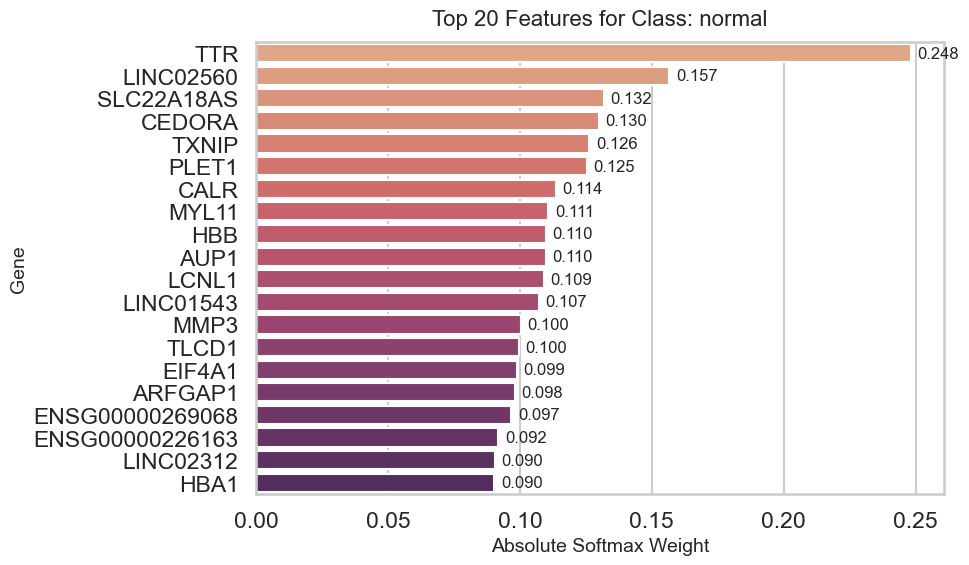

/var/folders/82/xgfcbtyj0mv3n0f77cv0vkdr0000gn/T/ipykernel_81136/251153931.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


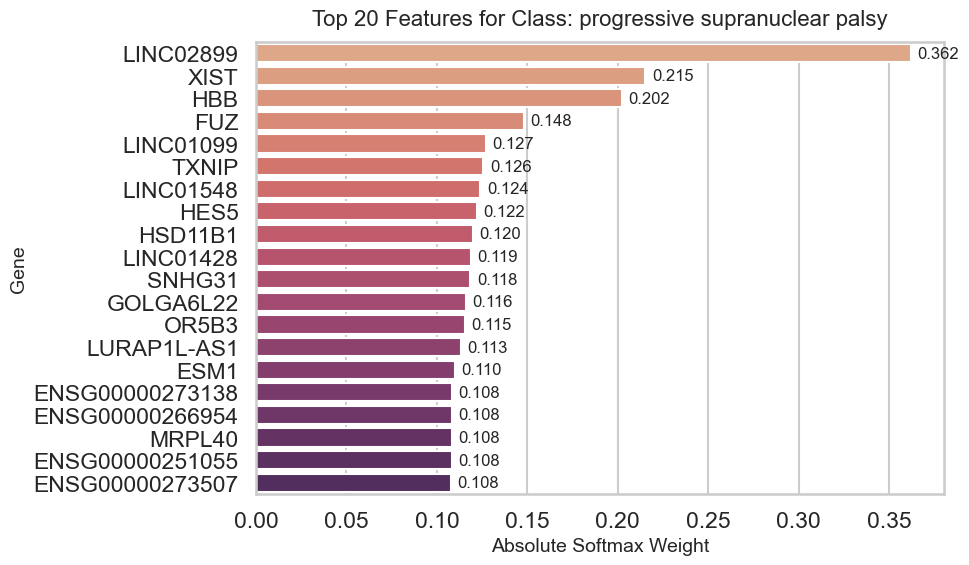

In [11]:
# ANALYSIS 3: Feature importance; plot the weight magnitudes of features (softmax coefficients)

''' 
Goal: Define a function that accepts Ensemble IDs (feature gene identifiers) and looks them up to procure the actual gene name from the Ensembl.org database. 
'''
def map_ensembl_to_symbol(ensembl_ids, batch_size=200):
    server   = "https://rest.ensembl.org"
    endpoint = "/lookup/id"
    headers  = {"Content-Type": "application/json"}
    mapping  = {}

    for i in range(0, len(ensembl_ids), batch_size):
        batch = ensembl_ids[i : i + batch_size]
        try:
            resp = requests.post(server + endpoint, headers=headers, json={"ids": batch})
            resp.raise_for_status()
            data = resp.json()
            for eid, info in data.items():
                mapping[eid] = info["display_name"] if info and "display_name" in info else eid
        except Exception as e:
            print(f"Warning: Ensembl lookup failed for batch {i}-{i+batch_size} → {e}")
            # fallback: use IDs as-is
            for eid in batch:
                mapping[eid] = eid

    return mapping


sns.set_theme(style="whitegrid", context="talk")

# Assuming map_ensembl_to_symbol is already defined,
# and X_train_z, final_model, topN are available

# Build weights DataFrame
weights_df = pd.DataFrame(
    final_model.W,
    index=X_train_z.columns,
    columns=final_model.classes_
)

topN = 20 # plot top 20 features

for cls in weights_df.columns:
    # get top-N by absolute weight for this class
    class_weights = (
        weights_df[cls]
        .abs()
        .sort_values(ascending=False)
        .head(topN)
    )
    # map Ensembl IDs → gene symbols
    mapping     = map_ensembl_to_symbol(class_weights.index.tolist())
    gene_labels = [mapping.get(eid, eid) for eid in class_weights.index]

    # plot with seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=class_weights.values,
        y=gene_labels,
        palette="flare"
    )
    ax.set_title(f"Top {topN} Features for Class: {cls}", fontsize=16, pad=12)
    ax.set_xlabel("Absolute Softmax Weight", fontsize=14)
    ax.set_ylabel("Gene", fontsize=14)

    # annotate bar values
    max_val = class_weights.values.max()
    for i, v in enumerate(class_weights.values):
        ax.text(
            v + max_val * 0.01, 
            i, 
            f"{v:.3f}", 
            va="center", 
            fontsize=12
        )

    plt.tight_layout()
    plt.show()

